# A Variational Perspective on Diffusion-Based Generative Models and Score Matching

Imane Elbacha, Nathan Weill

MVA 22 Generative Models

## 0. Imports

In [7]:
#general imports
import time
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#datasets
from sklearn.datasets import make_swiss_roll
from sklearn.datasets import make_s_curve
from sklearn.datasets import make_moons

## 1. Initialize dataset

### 1.1 Swiss Roll

The Swiss Roll dataset is a well-known synthetic dataset often used in machine learning and data visualization tasks. It is designed to test and demonstrate the capabilities of various algorithms in handling non-linear data and assessing their ability to capture complex patterns.

The Swiss Roll dataset is generated by creating a two-dimensional manifold in a three-dimensional space. The manifold is shaped like a rolled-up piece of paper or a spiral. The data points are distributed along this curved surface in a specific pattern. Each data point is associated with its position in the three-dimensional space and can be represented by three coordinates (x, y, z).

The dataset is called the "Swiss Roll" because when the data points are visualized in two dimensions by discarding the z-coordinate, they resemble a flat sheet of paper rolled into a spiral shape. The points on the innermost part of the roll are densely packed, while the points on the outer part are more spread out.

The Swiss Roll dataset is often used to evaluate and compare dimensionality reduction techniques, such as manifold learning algorithms, as it poses a challenge for linear methods. The goal is to unfold or unroll the Swiss Roll structure to reveal its underlying pattern or shape.

Researchers and practitioners use the Swiss Roll dataset to study and develop techniques for visualization, clustering, classification, and regression tasks. Its distinctive shape and properties make it a popular benchmark dataset in the field of machine learning.

In [2]:
class SwissRoll:
    """
    Swiss roll distribution sampler.
    noise control the amount of noise injected to make a thicker swiss roll
    """
    def sample(self, n, noise=0.5):
        if noise is None:
            noise = 0.5
        return torch.from_numpy(
            make_swiss_roll(n, noise=noise)[0][:, [0, 2]].astype('float32') / 5.)


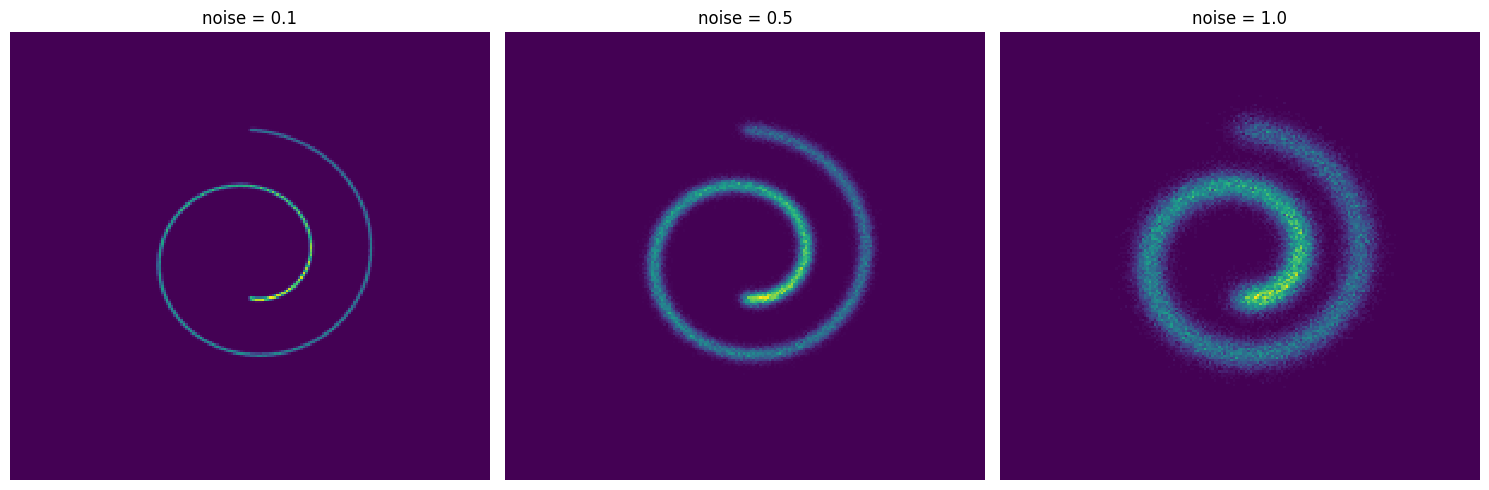

In [3]:
plt.close('all')
fig = plt.figure(figsize=(15, 5))
swiss_roll = SwissRoll()
for i, noise in enumerate([0.1, 0.5, 1.0]):
    x = swiss_roll.sample(n=100000, noise=noise).data.numpy()
    ax = fig.add_subplot(1, 3, i+1)
    _ = ax.hist2d(x[:,0], x[:,1], 200, range=((-5,5), (-5,5)))
    ax.axis('off')
    ax.set_title(f'noise = {noise}')
plt.tight_layout()


### 1.2 S curve


The S-curve dataset is a synthetic dataset commonly used in machine learning and data visualization tasks to evaluate algorithms' ability to handle non-linear data and capture complex patterns. It is designed to resemble the shape of the letter "S."

The S-curve dataset is generated by creating a three-dimensional manifold in a higher-dimensional space. The data points are distributed along the curved surface of the S-shaped manifold. Each data point is associated with its position in the three-dimensional space and can be represented by three coordinates (x, y, z).

The distribution of data points in the S-curve dataset is such that they form an S-shaped pattern when viewed in two dimensions by discarding the z-coordinate. The points on one side of the curve are densely packed, while the points on the other side are more spread out.

The purpose of using the S-curve dataset is to challenge algorithms to capture the non-linear structure of the data and uncover the underlying pattern. Since linear methods may struggle to handle such non-linear data, the S-curve dataset provides a suitable testbed for evaluating and comparing dimensionality reduction techniques and manifold learning algorithms.

In [5]:
class SCurve:
    """
    S curve distribution sampler.
    noise control the amount of noise injected to make a thicker S curve
    """
    def sample(self, n, noise=0.5):
        if noise is None:
            noise = 0.5
        return torch.from_numpy(
            make_s_curve(n, noise=noise)[0][:, [0, 2]].astype('float32') / 1.)

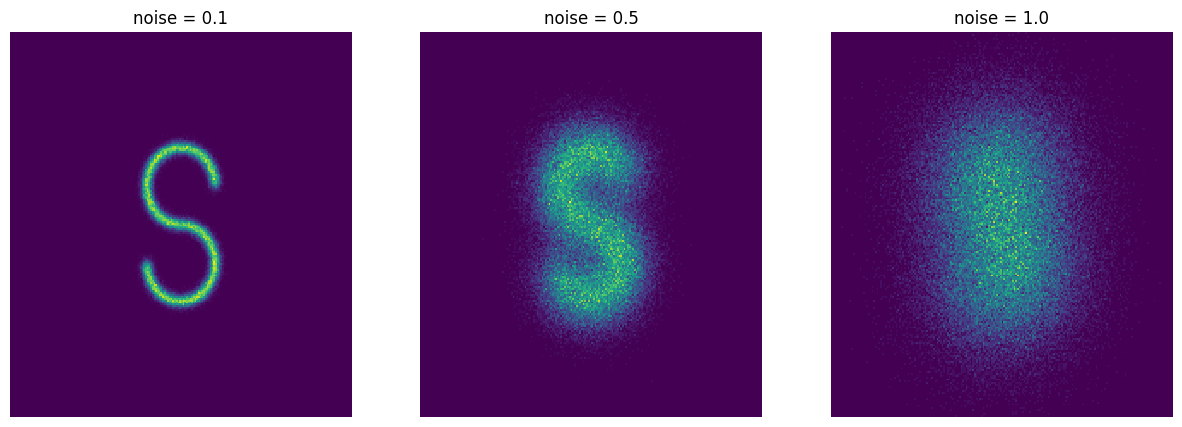

In [6]:
plt.close('all')
fig = plt.figure(figsize=(15, 5))
s_curve = SCurve()
for i, noise in enumerate([0.1, 0.5, 1.0]):
    x = s_curve.sample(n=100000, noise=noise).data.numpy()
    ax = fig.add_subplot(1, 3, i+1)
    _ = ax.hist2d(x[:,0], x[:,1], 200, range=((-5,5), (-5,5)))
    ax.axis('off')
    ax.set_title(f'noise = {noise}')

### 1.3 Moon dataset

The Moon dataset is a synthetic dataset commonly used in machine learning for classification tasks and evaluating algorithms' ability to handle non-linear data. It consists of two interleaving crescent moon-shaped clusters.

The Moon dataset is generated by creating two circular clusters in a two-dimensional space. Each cluster represents a separate class or category. The inner edges of the circles are connected, creating a concave shape resembling two crescent moons. The data points are distributed within these crescent moon shapes.

The purpose of the Moon dataset is to challenge algorithms to separate and classify the data points based on their complex geometric arrangement. The clusters are not linearly separable, which means that a straight line cannot effectively separate the two classes. This makes the Moon dataset suitable for evaluating non-linear classification algorithms.

Researchers and practitioners use the Moon dataset to develop and compare various machine learning techniques, such as support vector machines, neural networks, and decision trees, in handling non-linear data and testing their ability to capture complex patterns.

The Moon dataset serves as a benchmark to assess the performance of classification algorithms and evaluate their robustness in dealing with non-linear decision boundaries. By experimenting with different algorithms on this dataset, researchers can gain insights into the strengths and weaknesses of different approaches and explore techniques for improving classification accuracy on non-linear data.

In [8]:
class Moon:
    """
    Moon distribution sampler.
    noise control the amount of noise injected to make a thicker moon
    """
    def sample(self, n, noise=0.5):
        if noise is None:
            noise = 0.5
        return torch.from_numpy(
            make_moons(n, noise=noise)[0].astype('float32') / 1.)
    

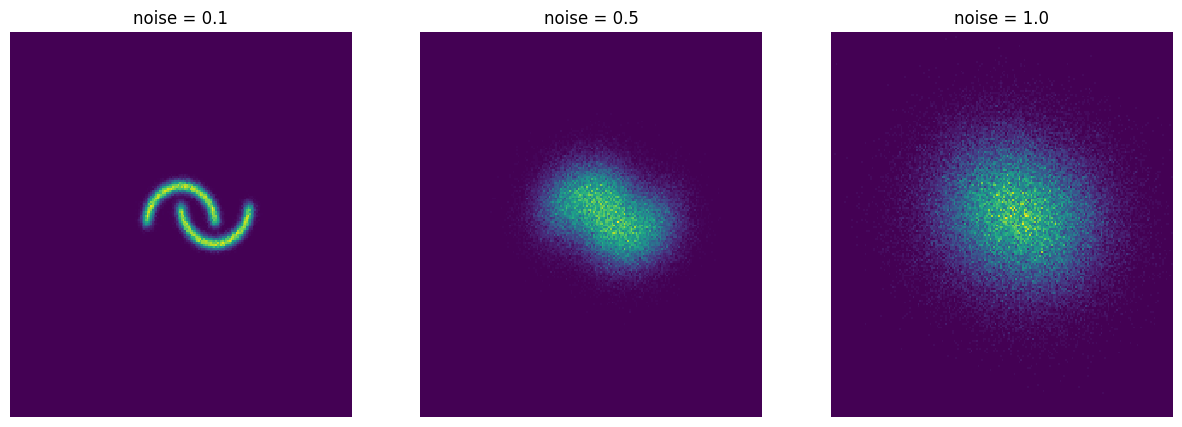

In [9]:
plt.close('all')
fig = plt.figure(figsize=(15, 5))
moon = Moon()
for i, noise in enumerate([0.1, 0.5, 1.0]):
    x = moon.sample(n=100000, noise=noise).data.numpy()
    ax = fig.add_subplot(1, 3, i+1)
    _ = ax.hist2d(x[:,0], x[:,1], 200, range=((-5,5), (-5,5)))
    ax.axis('off')
    ax.set_title(f'noise = {noise}')

## 2. Define models

### 2.1. Define SDEs

The provided code implements two stochastic differential equation (SDE) models: VariancePreservingSDE and PluginReverseSDE. Here's a clear explanation of each model:

1. VariancePreservingSDE:
- The VariancePreservingSDE class represents an SDE model called "variance preserving SDE" proposed by Song et al. (2021). This model captures the evolution of a stochastic process over time. Here are the key components and functionalities of this model:
Initialization: The VariancePreservingSDE class is initialized with parameters such as beta_min (lower bound of beta), beta_max (upper bound of beta), T (time horizon), and t_epsilon (lower bound of t).

- Drift and Diffusion Functions: The class defines functions such as f(t, y) (drift function) and g(t, y) (diffusion function). These functions determine how the process evolves over time. The drift function represents the trend or direction of change, while the diffusion function captures the randomness or volatility of the process.

- Sampling: The class provides a sample(t, y0, return_noise=False) method for sampling from the SDE. Given a time t, an initial value y0, and an optional argument return_noise, this method generates a sample from the SDE at the specified time. If return_noise is set to True, it also returns additional information such as the noise, standard deviation, and diffusion.

- Log-variance and Mean of Stationary Distribution: The class computes the log-variance and mean of the stationary distribution using the logvar_mean_T property.

2. PluginReverseSDE:
- The PluginReverseSDE class represents a reverse SDE model that inverts a given base SDE with drift f and diffusion g, along with an inference SDE's drift a. This model is used for denoising score matching and estimating the evidence lower bound (ELBO). Here's an explanation of its main features:
- Initialization: The PluginReverseSDE class is initialized with a base SDE, a drift function a, a time horizon T, and optional parameters such as vtype (type of distribution for sampling) and debias (whether to use non-uniform sampling to debias the weight).

- Drift and Diffusion Functions: The class defines the mu(t, y, lmbd=0.) function for the drift and the sigma(t, y, lmbd=0.) function for the diffusion. These functions compute the drift and diffusion at a given time t and value y.

- Denoising Score Matching: The class provides the dsm(x) method for calculating the denoising score matching loss. This loss measures the discrepancy between the gradient of the model and the noise-added data.

- ELBO Estimation: The class offers the elbo_random_t_slice(x) method for estimating the evidence lower bound (ELBO) by sampling t uniformly between 0 and T. It uses the Hutchinson trace estimator to estimate the divergence term and combines it with log-probability and quadratic terms.

These implementations enable the simulation, sampling, and estimation of SDE models, facilitating tasks such as denoising score matching and ELBO estimation for generative modeling and inference.

In [10]:
Log2PI = float(np.log(2 * np.pi))

def log_normal(x, mean, log_var, eps=0.00001):
    '''
    log pdf of normal distribution
    '''
    z = - 0.5 * Log2PI
    return - (x - mean) ** 2 / (2. * torch.exp(log_var) + eps) - log_var / 2. + z

def sample_rademacher(shape):
    '''
    sample from Rademacher distribution
    rademacher distribution is a discrete distribution with probability mass function
    P(X = 1) = P(X = -1) = 0.5
    '''
    return (torch.rand(*shape).ge(0.5)).float() * 2 - 1

def sample_gaussian(shape):
    '''
    sample from Gaussian distribution
    '''

    return torch.randn(*shape)

def sample_v(shape, vtype='rademacher'):
    '''
    sample from Rademacher or Gaussian distribution
    '''
    if vtype == 'rademacher':
        return sample_rademacher(shape)
    elif vtype == 'normal' or vtype == 'gaussian':
        return sample_gaussian(shape)
    else:
        Exception(f'vtype {vtype} not supported')

In [12]:
class VariancePreservingSDE(torch.nn.Module):
    """
    Implementation of the variance preserving SDE proposed by Song et al. 2021
    See eq (32-33) of https://openreview.net/pdf?id=PxTIG12RRHS
    params:
    beta_min: float, lower bound of beta
    beta_max: float, upper bound of beta
    T: float, time horizon
    t_epsilon: float, lower bound of t
    output:
    yt: tensor, sample from the variance preserving SDE
    """
    def __init__(self, beta_min=0.1, beta_max=20.0, T=1.0, t_epsilon=0.001):
        super().__init__()
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.T = T
        self.t_epsilon = t_epsilon

    @property
    def logvar_mean_T(self):
        """
        logvar and mean of the stationary distribution
        """
        logvar = torch.zeros(1)
        mean = torch.zeros(1)
        return logvar, mean

    def beta(self, t):
        '''
        function that maps t to beta
        beta(t) = beta_min + (beta_max - beta_min) * t
        '''
        return self.beta_min + (self.beta_max-self.beta_min)*t

    def mean_weight(self, t):
        '''
        function that maps t to mean weight
        mean_weight(t) = exp(-0.25 * t**2 * (beta_max - beta_min) - 0.5 * t * beta_min)
        '''
        return torch.exp(-0.25 * t**2 * (self.beta_max-self.beta_min) - 0.5 * t * self.beta_min)

    def var(self, t):
        '''
        function that maps t to variance
        var(t) = 1 - exp(-0.5 * t**2 * (beta_max - beta_min) - t * beta_min)
        '''
        return 1. - torch.exp(-0.5 * t**2 * (self.beta_max-self.beta_min) - t * self.beta_min)

    def f(self, t, y):
        '''
        drift function
        f(t, y) = - 0.5 * beta(t) * y
        '''
        return - 0.5 * self.beta(t) * y

    def g(self, t, y):
        '''
        diffusion function
        g(t, y) = beta(t)**0.5
        '''
        beta_t = self.beta(t)
        return torch.ones_like(y) * beta_t**0.5

    def sample(self, t, y0, return_noise=False):
        """
        sample yt | y0
        if return_noise=True, also return std and g for reweighting the denoising score matching loss
        """
        mu = self.mean_weight(t) * y0
        std = self.var(t) ** 0.5
        epsilon = torch.randn_like(y0)
        yt = epsilon * std + mu
        if not return_noise:
            return yt
        else:
            return yt, epsilon, std, self.g(t, yt)

    def sample_debiasing_t(self, shape):
        """
        non-uniform sampling of t to debias the weight std^2/g^2
        the sampling distribution is proportional to g^2/std^2 for t >= t_epsilon
        for t < t_epsilon, it's truncated
        """
        #implement the sampling distribution
        #return sample_vp_truncated_q(shape, self.beta_min, self.beta_max, t_epsilon=self.t_epsilon, T=self.T)
    

    
    




In [13]:
class PluginReverseSDE(torch.nn.Module):
    """
    inverting a given base sde with drift `f` and diffusion `g`, and an inference sde's drift `a` by
    f <- g a - f
    g <- g
    (time is inverted)
    """
    def __init__(self, base_sde, drift_a, T, vtype='rademacher', debias=False):
        super().__init__()
        self.base_sde = base_sde
        self.a = drift_a
        self.T = T
        self.vtype = vtype
        self.debias = debias

    # Drift
    def mu(self, t, y, lmbd=0.):
        return (1. - 0.5 * lmbd) * self.base_sde.g(self.T-t, y) * self.a(y, self.T - t.squeeze()) - \
               self.base_sde.f(self.T - t, y)

    # Diffusion
    def sigma(self, t, y, lmbd=0.):
        return (1. - lmbd) ** 0.5 * self.base_sde.g(self.T-t, y)

    @torch.enable_grad()
    def dsm(self, x):
        """
        denoising score matching loss
        """
        if self.debias:
            t_ = self.base_sde.sample_debiasing_t([x.size(0), ] + [1 for _ in range(x.ndim - 1)])
        else:
            t_ = torch.rand([x.size(0), ] + [1 for _ in range(x.ndim - 1)]).to(x) * self.T
        y, target, std, g = self.base_sde.sample(t_, x, return_noise=True)
        a = self.a(y, t_.squeeze())

        return ((a * std / g + target) ** 2).view(x.size(0), -1).sum(1, keepdim=False) / 2

    @torch.enable_grad()
    def elbo_random_t_slice(self, x):
        """
        estimating the ELBO of the plug-in reverse SDE by sampling t uniformly between [0, T], and by estimating
        div(mu) using the Hutchinson trace estimator
        """
        t_ = torch.rand([x.size(0), ] + [1 for _ in range(x.ndim - 1)]).to(x) * self.T
        qt = 1 / self.T
        y = self.base_sde.sample(t_, x).requires_grad_()

        a = self.a(y, t_.squeeze())
        mu = self.base_sde.g(t_, y) * a - self.base_sde.f(t_, y)

        v = sample_v(x.shape, vtype=self.vtype).to(y)

        Mu = - (
              torch.autograd.grad(mu, y, v, create_graph=self.training)[0] * v
        ).view(x.size(0), -1).sum(1, keepdim=False) / qt

        Nu = - (a ** 2).view(x.size(0), -1).sum(1, keepdim=False) / 2 / qt
        yT = self.base_sde.sample(torch.ones_like(t_) * self.base_sde.T, x)
        lp = log_normal(yT, torch.zeros_like(yT), torch.zeros_like(yT)).view(x.size(0), -1).sum(1)

        return lp + Mu + Nu

### 2.2. Define MLP

In [14]:
class Swish(nn.Module):
    '''
    Swish activation function
    '''
    def __init__(self):
        super().__init__()

    def forward(self, x): 
        return torch.sigmoid(x)*x

class MLP(nn.Module):
    '''
    MLP with 3 hidden layers
    '''
    
    def __init__(self,
                 input_dim=2,
                 index_dim=1,
                 hidden_dim=128,
                 act=Swish(),
                 ):
        super().__init__()
        self.input_dim = input_dim
        self.index_dim = index_dim
        self.hidden_dim = hidden_dim
        self.act = act

        self.main = nn.Sequential(
            nn.Linear(input_dim+index_dim, hidden_dim),
            act,
            nn.Linear(hidden_dim, hidden_dim),
            act,
            nn.Linear(hidden_dim, hidden_dim),
            act,
            nn.Linear(hidden_dim, input_dim),
            )

    def forward(self, input, t):
        # init
        sz = input.size()
        input = input.view(-1, self.input_dim)
        t = t.view(-1, self.index_dim).float()

        # forward
        h = torch.cat([input, t], dim=1) # concat
        output = self.main(h) # forward
        return output.view(*sz)

### 2.3. Define evaluate function (compute ELBO)


In [15]:
@torch.no_grad()
def evaluate(gen_sde, x_test):
    '''
    evaluate the ELBO of the plug-in reverse SDE on the test set
    '''
    gen_sde.eval()
    num_samples = x_test.size(0)
    test_elbo = gen_sde.elbo_random_t_slice(x_test)
    gen_sde.train()
    return test_elbo.mean(), test_elbo.std() / num_samples ** 0.5

## 3. Train

### 3.1 Swiss Roll training

use gpu

| iter   5000 |  3.38 ms/step | loss    0.351 | elbo   -2.909 | elbo std    0.738 
| iter  10000 |  2.51 ms/step | loss    0.271 | elbo   -3.501 | elbo std    0.860 
| iter  15000 |  2.81 ms/step | loss    0.277 | elbo   -0.278 | elbo std    0.713 
| iter  20000 |  3.18 ms/step | loss    0.250 | elbo   -0.938 | elbo std    0.873 
| iter  25000 |  3.62 ms/step | loss    0.226 | elbo   -2.329 | elbo std    0.827 
| iter  30000 |  3.20 ms/step | loss    0.314 | elbo   -1.867 | elbo std    0.887 
| iter  35000 |  2.66 ms/step | loss    0.277 | elbo   -1.874 | elbo std    0.901 
| iter  40000 |  2.48 ms/step | loss    0.290 | elbo   -1.345 | elbo std    0.852 
| iter  45000 |  2.49 ms/step | loss    0.315 | elbo   -3.438 | elbo std    0.940 
| iter  50000 |  2.50 ms/step | loss    0.273 | elbo   -2.126 | elbo std    0.842 
| iter  55000 |  2.67 ms/step | loss    0.245 | elbo   -1.877 | elbo std    0.928 
| iter  60000 |  3.19 ms/step | loss    0.358 | elbo   -2.350 | elbo std    1.

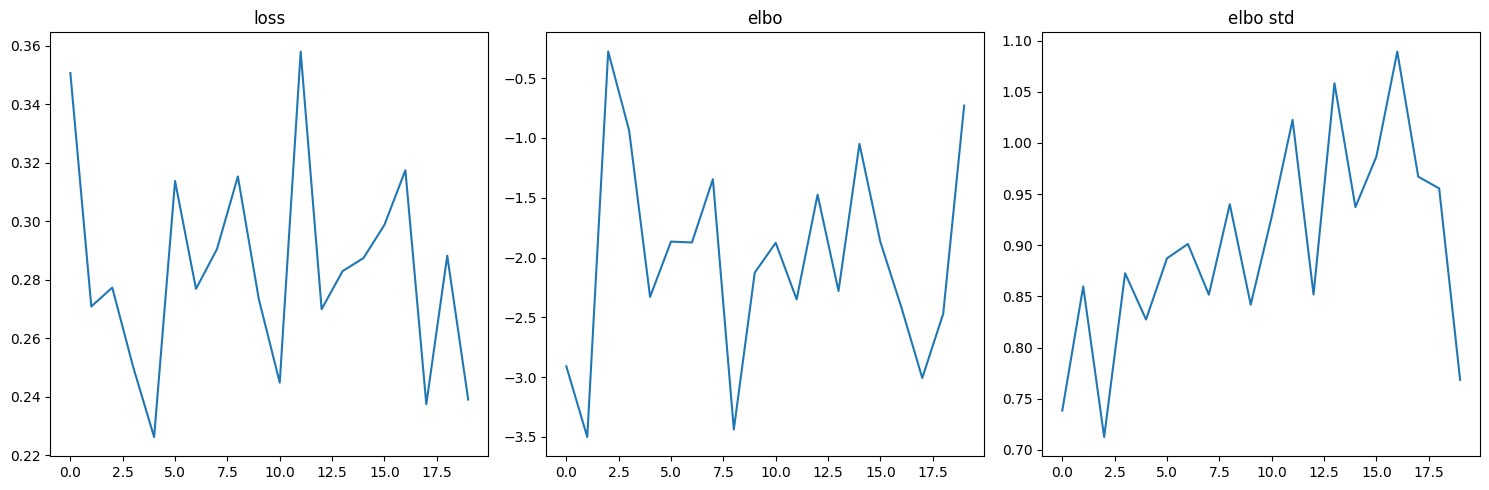

In [16]:
# init device
if torch.cuda.is_available():
    device = 'cuda'
    print('use gpu\n')
else:
    device = 'cpu'
    print('use cpu\n')

# arguments
T0 = 1
vtype = 'rademacher'
lr = 0.001
batch_size = 256
iterations = 100000
print_every = 5000

# init sampler
sampler = SwissRoll()

# init models
drift_q = MLP(input_dim=2, index_dim=1, hidden_dim=128).to(device)
T = torch.nn.Parameter(torch.FloatTensor([T0]), requires_grad=False)
inf_sde = VariancePreservingSDE(beta_min=0.1, beta_max=20.0, T=T)
gen_sde_swissroll = PluginReverseSDE(inf_sde, drift_q, T, vtype=vtype, debias=False).to(device)

# init optimizer
optim = torch.optim.Adam(gen_sde_swissroll.parameters(), lr=lr)

# train
losses = list()
elbos = list()
elbo_stds = list()
start_time = time.time()
for i in range(iterations):
    optim.zero_grad() # init optimizer
    x = sampler.sample(batch_size).to(device) # sample data
    loss = gen_sde_swissroll.dsm(x).mean() # forward and compute loss
    loss.backward() # backward
    optim.step() # update

    # print
    if (i+1) % print_every == 0:
        # elbo
        elbo, elbo_std = evaluate(gen_sde_swissroll, x)

        # print
        losses.append(loss.item())
        elbos.append(elbo.item())
        elbo_stds.append(elbo_std.item())
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} | elbo {:8.3f} | elbo std {:8.3f} '
              .format(i+1, elapsed*1000/print_every, loss.item(), elbo.item(), elbo_std.item()))
        start_time = time.time()

# plot
plt.close('all')
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.plot(losses)
ax.set_title('loss')
ax = fig.add_subplot(1, 3, 2)
ax.plot(elbos)
ax.set_title('elbo')
ax = fig.add_subplot(1, 3, 3)
ax.plot(elbo_stds)
ax.set_title('elbo std')
plt.tight_layout()

### 3.2 S curve training 

use gpu

| iter   5000 |  2.48 ms/step | loss    0.289 | elbo   -3.192 | elbo std    0.687 
| iter  10000 |  2.48 ms/step | loss    0.269 | elbo   -2.962 | elbo std    0.736 
| iter  15000 |  2.51 ms/step | loss    0.266 | elbo   -2.180 | elbo std    0.696 
| iter  20000 |  2.52 ms/step | loss    0.241 | elbo   -4.181 | elbo std    0.719 
| iter  25000 |  2.48 ms/step | loss    0.277 | elbo   -1.651 | elbo std    0.676 
| iter  30000 |  2.51 ms/step | loss    0.271 | elbo   -1.057 | elbo std    0.588 
| iter  35000 |  2.48 ms/step | loss    0.325 | elbo   -3.153 | elbo std    0.731 
| iter  40000 |  2.53 ms/step | loss    0.281 | elbo   -2.275 | elbo std    0.661 
| iter  45000 |  2.48 ms/step | loss    0.241 | elbo   -2.065 | elbo std    0.656 
| iter  50000 |  2.46 ms/step | loss    0.331 | elbo   -4.231 | elbo std    0.852 
| iter  55000 |  2.47 ms/step | loss    0.304 | elbo   -3.266 | elbo std    0.669 
| iter  60000 |  2.46 ms/step | loss    0.317 | elbo   -2.645 | elbo std    0.

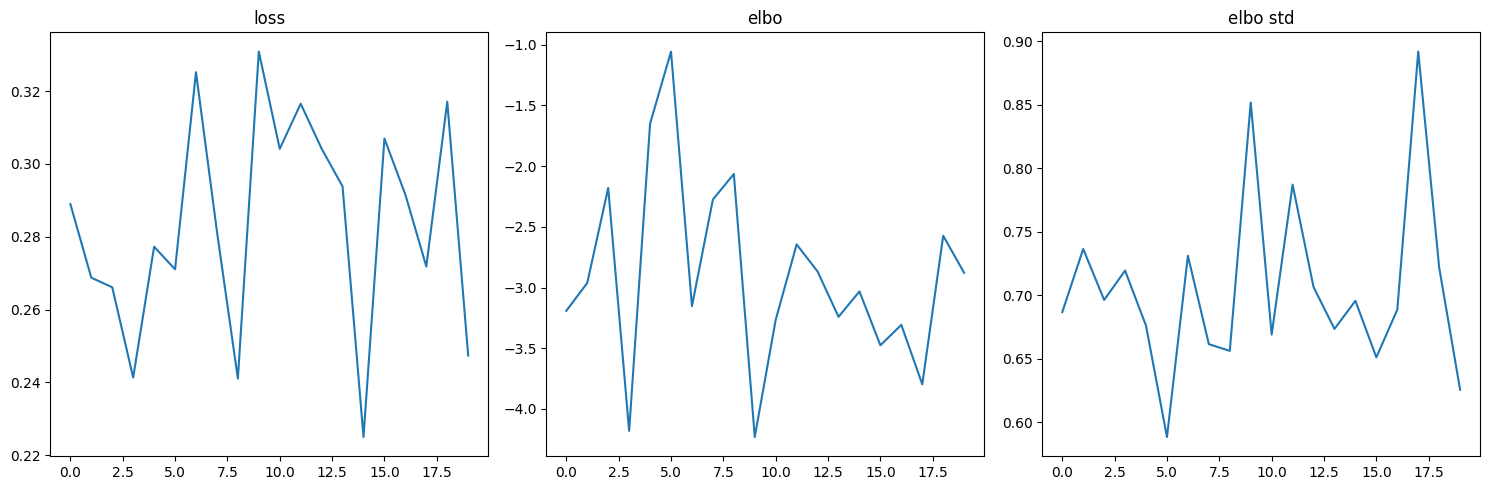

In [17]:
# init device
if torch.cuda.is_available():
    device = 'cuda'
    print('use gpu\n')
else:
    device = 'cpu'
    print('use cpu\n')

# arguments
T0 = 1
vtype = 'rademacher'
lr = 0.001
batch_size = 256
iterations = 100000
print_every = 5000

# init sampler
sampler =   SCurve()

# init models
drift_q = MLP(input_dim=2, index_dim=1, hidden_dim=128).to(device)
T = torch.nn.Parameter(torch.FloatTensor([T0]), requires_grad=False)
inf_sde = VariancePreservingSDE(beta_min=0.1, beta_max=20.0, T=T).to(device)
gen_sde_scurve = PluginReverseSDE(inf_sde, drift_q, T, vtype=vtype, debias=False).to(device)

# init optimizer
optim = torch.optim.Adam(gen_sde_scurve.parameters(), lr=lr)

# train
losses = list()
elbos = list()
elbo_stds = list()
start_time = time.time()
for i in range(iterations):
    optim.zero_grad() # init optimizer
    x = sampler.sample(batch_size).to(device) # sample data
    loss = gen_sde_scurve.dsm(x).mean() # forward and compute loss
    loss.backward() # backward
    optim.step() # update

    # print
    if (i+1) % print_every == 0:
        # elbo
        elbo, elbo_std = evaluate(gen_sde_scurve, x)

        # print
        losses.append(loss.item())
        elbos.append(elbo.item())
        elbo_stds.append(elbo_std.item())
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} | elbo {:8.3f} | elbo std {:8.3f} '
              .format(i+1, elapsed*1000/print_every, loss.item(), elbo.item(), elbo_std.item()))
        start_time = time.time()

# plot
plt.close('all')
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.plot(losses)
ax.set_title('loss')
ax = fig.add_subplot(1, 3, 2)
ax.plot(elbos)
ax.set_title('elbo')
ax = fig.add_subplot(1, 3, 3)
ax.plot(elbo_stds)
ax.set_title('elbo std')
plt.tight_layout()


### 3.3 Moon dataset

use gpu

| iter   5000 |  2.79 ms/step | loss    0.252 | elbo   -1.863 | elbo std    0.654 
| iter  10000 |  2.82 ms/step | loss    0.258 | elbo   -1.995 | elbo std    0.680 
| iter  15000 |  2.78 ms/step | loss    0.225 | elbo   -3.588 | elbo std    0.881 
| iter  20000 |  2.76 ms/step | loss    0.212 | elbo   -2.486 | elbo std    0.624 
| iter  25000 |  2.75 ms/step | loss    0.253 | elbo   -2.012 | elbo std    0.778 
| iter  30000 |  2.80 ms/step | loss    0.240 | elbo   -2.598 | elbo std    0.764 
| iter  35000 |  2.82 ms/step | loss    0.251 | elbo   -2.639 | elbo std    0.751 
| iter  40000 |  2.80 ms/step | loss    0.185 | elbo   -1.807 | elbo std    0.641 
| iter  45000 |  2.73 ms/step | loss    0.307 | elbo   -2.797 | elbo std    0.792 
| iter  50000 |  2.75 ms/step | loss    0.254 | elbo   -1.976 | elbo std    0.790 
| iter  55000 |  2.80 ms/step | loss    0.283 | elbo   -2.948 | elbo std    0.802 
| iter  60000 |  2.82 ms/step | loss    0.286 | elbo   -1.486 | elbo std    0.

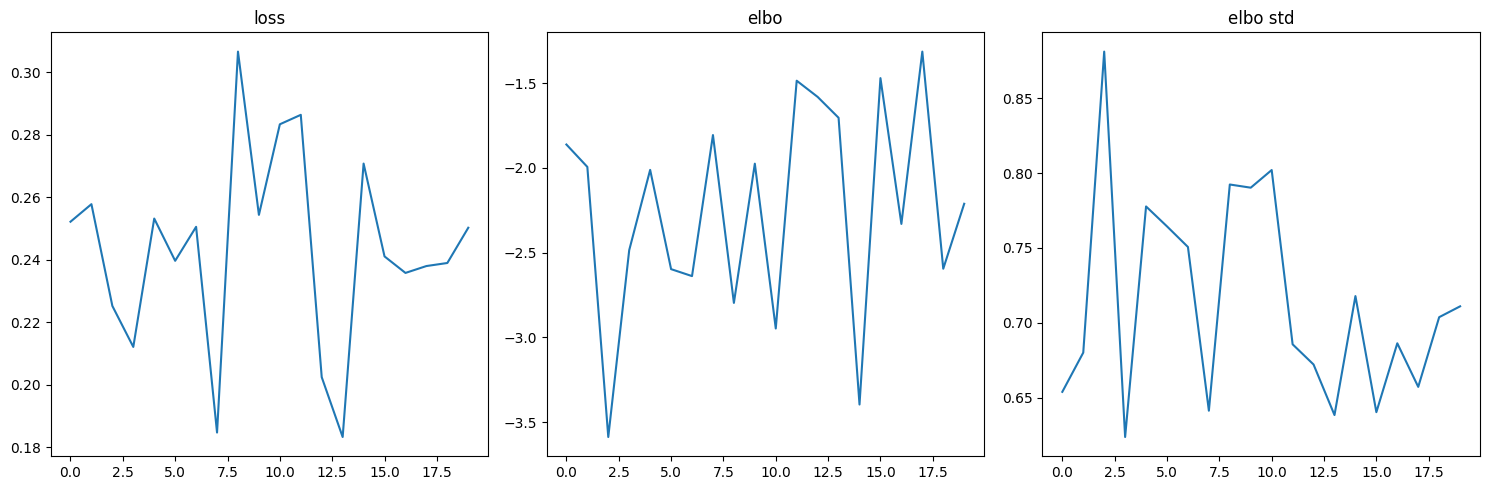

In [18]:
# init device
if torch.cuda.is_available():
    device = 'cuda'
    print('use gpu\n')
else:
    device = 'cpu'
    print('use cpu\n')

# arguments
T0 = 1
vtype = 'rademacher'
lr = 0.001
batch_size = 256
iterations = 100000
print_every = 5000

# init sampler
sampler =   Moon()

# init models
drift_q = MLP(input_dim=2, index_dim=1, hidden_dim=128).to(device)
T = torch.nn.Parameter(torch.FloatTensor([T0]), requires_grad=False)
inf_sde = VariancePreservingSDE(beta_min=0.1, beta_max=20.0, T=T).to(device)
gen_sde_moon = PluginReverseSDE(inf_sde, drift_q, T, vtype=vtype, debias=False).to(device)

# init optimizer
optim = torch.optim.Adam(gen_sde_moon.parameters(), lr=lr)

# train
losses = list()
elbos = list()
elbo_stds = list()
start_time = time.time()
for i in range(iterations):
    optim.zero_grad() # init optimizer
    x = sampler.sample(batch_size).to(device) # sample data
    loss = gen_sde_moon.dsm(x).mean() # forward and compute loss
    loss.backward() # backward
    optim.step() # update

    # print
    if (i+1) % print_every == 0:
        # elbo
        elbo, elbo_std = evaluate(gen_sde_moon, x)

        # print
        losses.append(loss.item())
        elbos.append(elbo.item())
        elbo_stds.append(elbo_std.item())
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} | elbo {:8.3f} | elbo std {:8.3f} '
              .format(i+1, elapsed*1000/print_every, loss.item(), elbo.item(), elbo_std.item()))
        start_time = time.time()

# plot
plt.close('all')
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.plot(losses)
ax.set_title('loss')
ax = fig.add_subplot(1, 3, 2)
ax.plot(elbos)
ax.set_title('elbo')
ax = fig.add_subplot(1, 3, 3)
ax.plot(elbo_stds)
ax.set_title('elbo std')
plt.tight_layout()

## 4. Visualize

### 4.1. Define plotting tools

In [19]:
def get_2d_histogram_plot(data, val=5, num=256, use_grid=False, origin='lower'):
    xmin = -val
    xmax = val 
    ymin = -val
    ymax = val 

    # get data
    x = data[:, 0]
    y = data[:, 1]

    # get histogram
    heatmap, xedges, yedges = np.histogram2d(x, y, range=[[xmin, xmax], [ymin, ymax]], bins=num)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    # plot heatmap
    fig, ax = plt.subplots(figsize=(5, 5)) 
    im = ax.imshow(heatmap.T, extent=extent, cmap='jet', origin=origin)
    ax.grid(False)
    if use_grid:
        plt.xticks(np.arange(-val, val+1, step=1))
        plt.yticks(np.arange(-val, val+1, step=1))
    else:
        plt.xticks([])
        plt.yticks([])

    # tight
    plt.tight_layout()

    # draw to canvas
    fig.canvas.draw()  # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    # close figure
    plt.close()
    return image

def plot_selected_inds(xs, inds, use_xticks=True, use_yticks=True):
    imgs_ = []
    for ind in inds:
        imgs_ += [get_2d_histogram_plot(xs[ind].numpy())]
    img_ = np.concatenate(imgs_, axis=1)

    height, width, _ = img_.shape
    height_per_img = width_per_img = height
    figwidth = 25
    fontsize = 15
    if use_xticks:
        xticks = [0.5*width_per_img + width_per_img*i for i in range(len(inds))]
        xticklabels = [r'$i={:d}$'.format(ind+1) for ind in inds]
    else:
        xticks, xticklabels = [], []
    if use_yticks:
        yticks = [0.5*height_per_img]
        yticklabels = [r'$\lambda={:.2g}$'.format(lmbd)]
    else:
        yticks, yticklabels = [], []

    fig = plt.figure(figsize=(figwidth, figwidth*height/width))
    ax = fig.add_subplot(111)
    ax.imshow(img_)
    axis_color = 'white' #'white'
    ax.spines['bottom'].set_color(axis_color)
    ax.spines['top'].set_color(axis_color)
    ax.spines['left'].set_color(axis_color)
    ax.spines['right'].set_color(axis_color)
    ax.tick_params(axis='x', colors=axis_color)
    ax.tick_params(axis='y', colors=axis_color)
    plt.xticks(xticks, xticklabels, color='black', fontsize=fontsize)
    plt.yticks(yticks, yticklabels, color='black', fontsize=fontsize)
    plt.show()

### 4.2. Define Euler Maruyama method with a step size $\Delta t$

The Euler-Maruyama method, also known as the Euler-Maruyama sampler, is a numerical approximation technique used to simulate stochastic differential equations (SDEs). It is an extension of the Euler method for ordinary differential equations (ODEs) that accounts for the presence of stochastic noise.

To understand the Euler-Maruyama method, let's start by considering a generic SDE of the form:

dX(t) = f(X(t), t) dt + g(X(t), t) dW(t)

Here, X(t) represents the state variable of the system at time t, f(X(t), t) is the deterministic drift term, g(X(t), t) is the diffusion term, and dW(t) represents the increment of a standard Wiener process (also known as Brownian motion) at time t.

The Euler-Maruyama method provides a discrete approximation to the SDE by discretizing the time interval into smaller steps. Given an initial condition X(0) = x0, the algorithm proceeds as follows:

Set the initial time t = 0 and the initial state X(t) = x0.
Specify the step size Δt.
Repeat the following steps until reaching the desired end time T:

a. Generate a random number ε from a standard normal distribution.

b. Compute the deterministic drift term: ΔX_det = f(X(t), t) Δt.

c. Compute the diffusion term: ΔX_diff = g(X(t), t) ε √(Δt).

d. Update the state: X(t+Δt) = X(t) + ΔX_det + ΔX_diff.

e. Increment the time: t = t + Δt.

By iterating through these steps, the Euler-Maruyama method generates a sequence of approximate state values X(t) at different time points. The method takes advantage of the fact that the Wiener process increments, dW(t), have mean zero and variance Δt, which are used to scale the random number ε in the diffusion term.

It's important to note that the Euler-Maruyama method is a first-order method and introduces some discretization error due to the simplifications made in the approximation. As a result, it may not accurately capture certain behaviors of complex SDEs, especially those with strong nonlinearity or high-frequency noise components. Higher-order methods, such as the Milstein method, can be used to reduce the discretization error.

When using the Euler-Maruyama method, it's crucial to select an appropriate step size Δt. A smaller step size generally leads to a more accurate approximation but at the cost of increased computational time. On the other hand, a larger step size can reduce computation time but may result in less accurate simulations. The choice of step size depends on the specific problem being modeled and the desired trade-off between accuracy and computational efficiency.

Overall, the Euler-Maruyama method is a widely used technique for numerically simulating SDEs and is particularly useful for understanding the behavior of stochastic systems in various fields, including finance, physics, and biology.

In [20]:
def euler_maruyama_sampler(sde, x_0, num_steps, lmbd=0., keep_all_samples=True):
    """
    Euler Maruyama method with a step size delta
    Euler Maruyama method is a numerical method to solve stochastic differential equations
    """
    # init
    device = sde.T.device
    batch_size = x_0.size(0)
    ndim = x_0.dim()-1
    T_ = sde.T.cpu().item()
    delta = T_ / num_steps
    ts = torch.linspace(0, 1, num_steps + 1) * T_
    
    # sample
    xs = []
    x_t = x_0.detach().clone().to(device)
    t = torch.zeros(batch_size, *([1]*ndim), device=device)
    with torch.no_grad():
        for i in range(num_steps):
            t.fill_(ts[i].item())
            mu = sde.mu(t, x_t, lmbd=lmbd)
            sigma = sde.sigma(t, x_t, lmbd=lmbd)
            x_t = x_t + delta * mu + delta ** 0.5 * sigma * torch.randn_like(x_t) # one step update of Euler Maruyama method with a step size delta
            if keep_all_samples or i == num_steps-1:
                xs.append(x_t.to('cpu'))
            else:
                pass
    return xs

### 4.3. Simulate SDEs

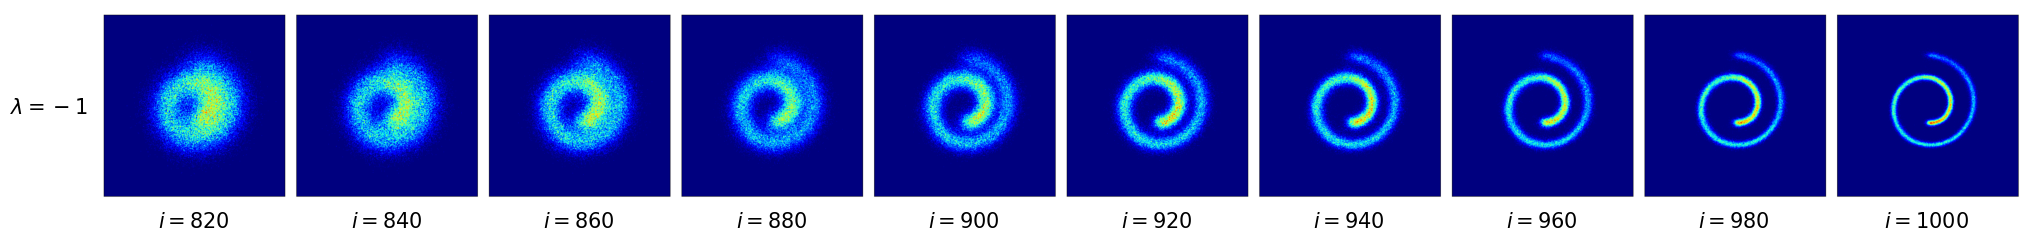

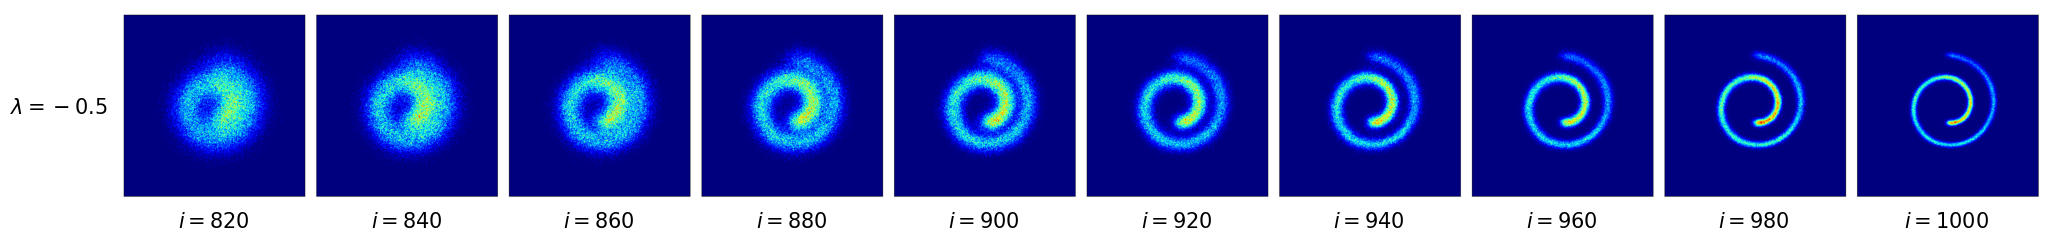

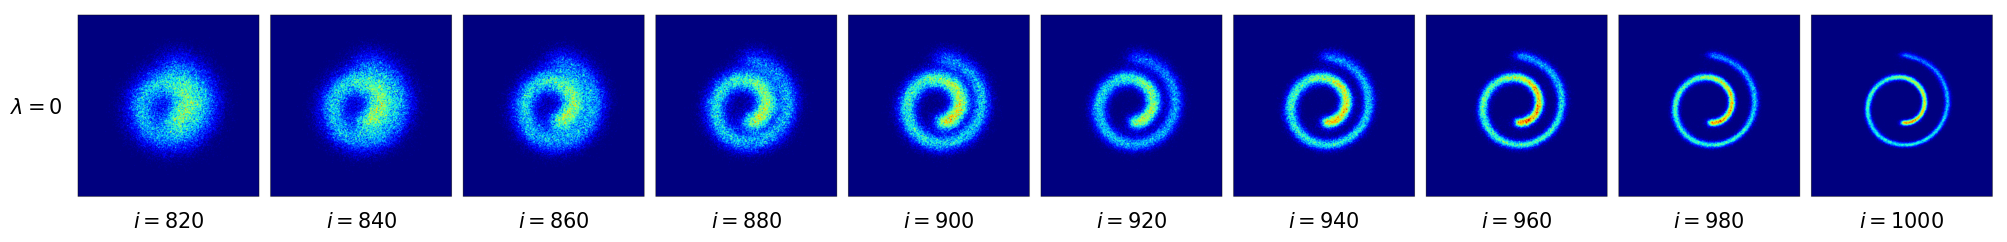

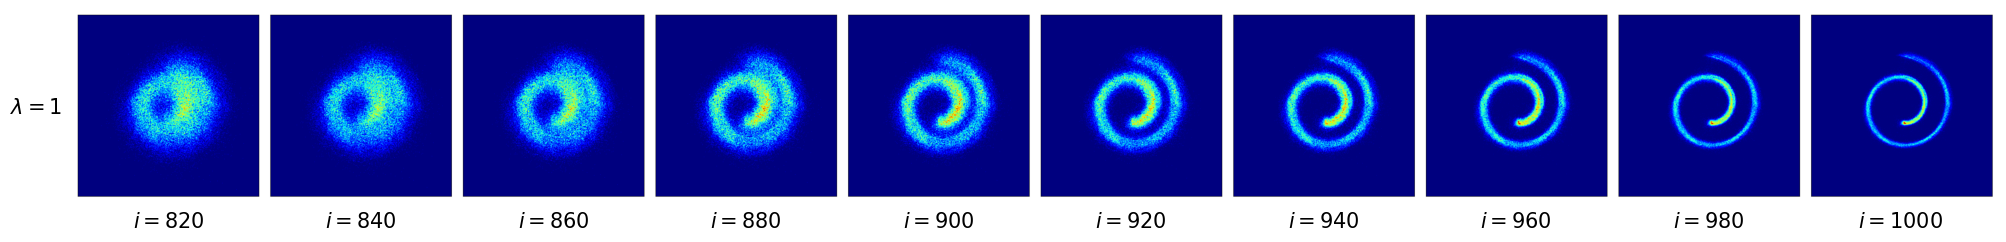

In [27]:
"""
Simulate the generative SDE by using Euler Maruyama method
"""
# init EM param
num_steps = 1000
num_samples = 100000

# lambdas
#lmbds = [0., 1.0]
lmbds = [-1, -0.5, 0.,  1.0]

# indices to visualize
num_figs = 10
fig_step = 20 #100
inds = [i-1 for i in range(num_steps-(num_figs-1)*fig_step, num_steps+1, fig_step)]

# sample and plot
plt.close('all')
for lmbd in lmbds:
    x_0 = torch.randn(num_samples, 2, device=device) # init from prior
    xs = euler_maruyama_sampler(gen_sde_swissroll, x_0, num_steps, lmbd=lmbd) # sample
    plot_selected_inds(xs, inds) # plot
    time.sleep(0.5)

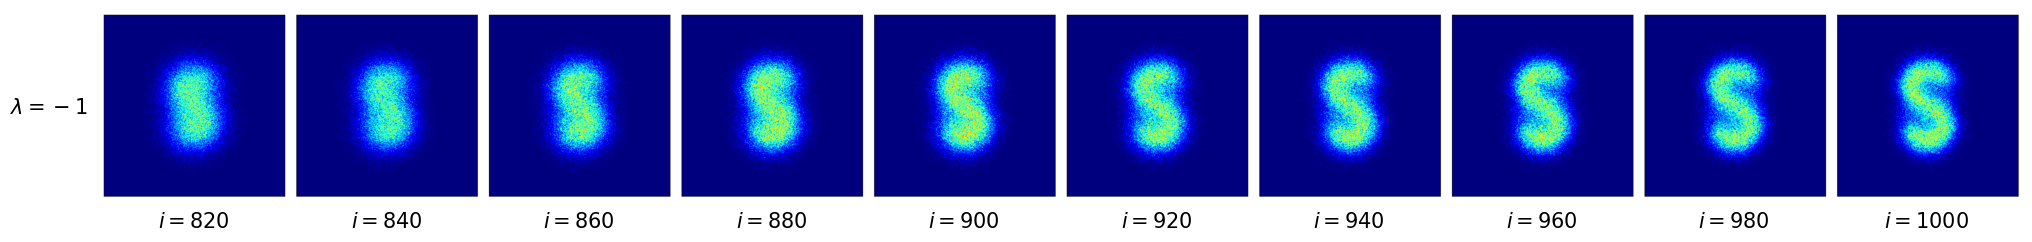

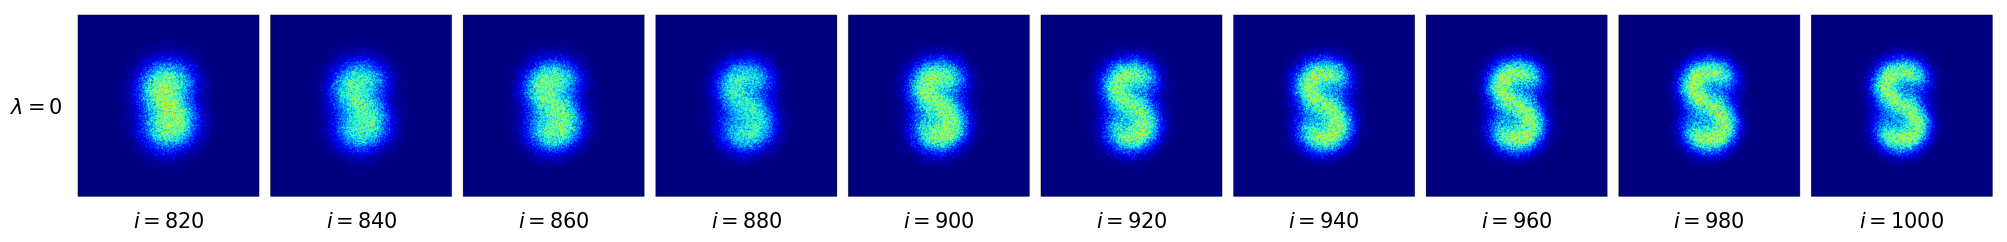

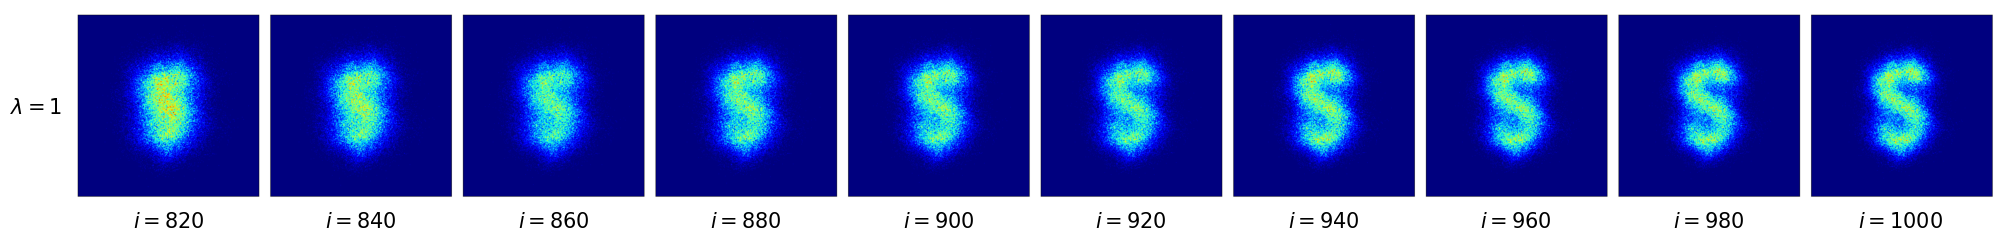

In [26]:
"""
Simulate the generative SDE by using Euler Maruyama method for the S curve distribution
"""
# init EM param
num_steps = 1000
num_samples = 100000

# lambdas
#lmbds = [0., 1.0]
lmbds = [-1, 0., 1.0]

# indices to visualize
num_figs = 10
fig_step = 20 #100
inds = [i-1 for i in range(num_steps-(num_figs-1)*fig_step, num_steps+1, fig_step)]

# sample and plot
plt.close('all')
for lmbd in lmbds:
    x_0 = torch.randn(num_samples, 2, device=device) # init from prior
    xs = euler_maruyama_sampler(gen_sde_scurve, x_0, num_steps, lmbd=lmbd) # sample
    plot_selected_inds(xs, inds) # plot
    time.sleep(0.5)




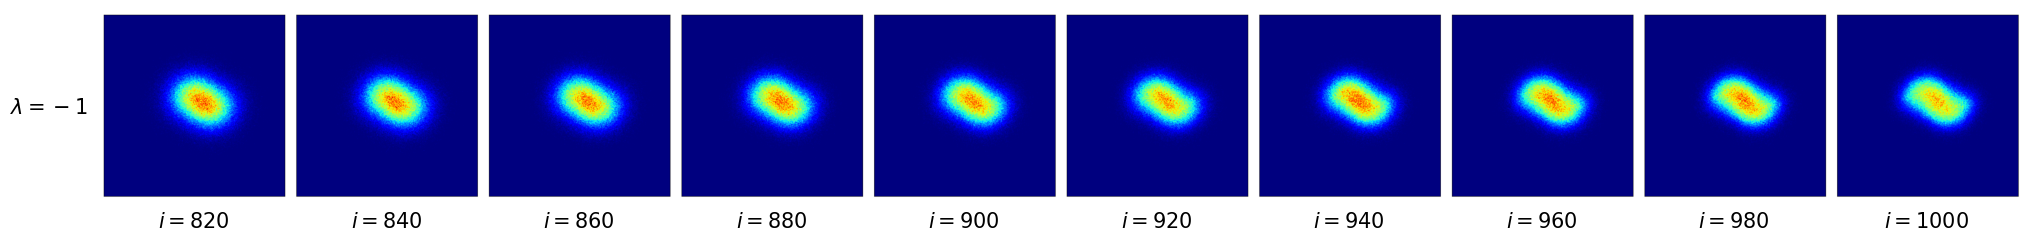

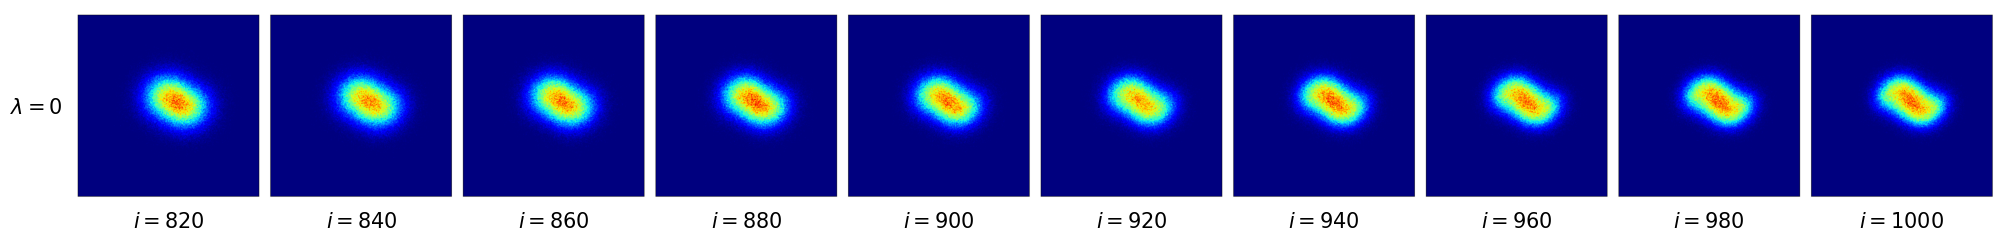

In [ ]:
"""
Simulate the generative SDE by using Euler Maruyama method
"""
# init EM param
num_steps = 1000
num_samples = 300000

# lambdas
#lmbds = [0., 1.0]
lmbds = [-1, 0.,  1.0]

# indices to visualize
num_figs = 10
fig_step = 20 #100
inds = [i-1 for i in range(num_steps-(num_figs-1)*fig_step, num_steps+1, fig_step)]

# sample and plot
plt.close('all')
for lmbd in lmbds:
    x_0 = torch.randn(num_samples, 2, device=device) # init from prior
    xs = euler_maruyama_sampler(gen_sde_moon, x_0, num_steps, lmbd=lmbd) # sample
    plot_selected_inds(xs, inds) # plot
    time.sleep(0.5)